In [ ]:
#importing libraries
import numpy as np
import pandas as pd
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
#importing data
data = pd.read_csv("telescope_data.csv")
data = data.drop(columns=['Unnamed: 0'])
data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [ ]:
#sampling dataset
data_g = data.loc[data['class']=='g']
data_h = data.loc[data['class']=='h']
data_g_downSampled = data_g.sample(data_h.shape[0], random_state=42)
data_downSampled = pd.concat([data_g_downSampled,data_h])
balanced_data = data_downSampled.sample(data_downSampled.shape[0],random_state=42)
balanced_data['class'] = balanced_data['class'].map({'g': 1, 'h': 0})

In [ ]:
#spliting dataset to x and y
X = balanced_data.drop(columns=['class']).values
y = balanced_data['class'].values
# Split the dataset: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=42, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp, random_state=42, test_size=0.5)
#printing training and validation and test datasets
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 9363, Validation: 2006, Test: 2007


In [ ]:
#euclidean distance functoin
def euclidean_distance(arr1,arr2):
    return np.sqrt(np.sum((arr1 - arr2) ** 2))

In [ ]:
#manual knn
def manual_kNN(X_train, y_train, X_val, k):
    y_pred = []
    for x in X_val:
        distances = [euclidean_distance(x, x_train) for x_train in X_train]
        k_nearest_indices = np.argsort(distances)[:k]
        k_nearest_labels = [y_train[i] for i in k_nearest_indices]
        voted_label = Counter(k_nearest_labels).most_common(1)[0][0]
        y_pred.append(voted_label)
    return np.array(y_pred)

In [ ]:
#computing optimal k value for both manual and scikit models
k_values = [1,3,5,7,9,11,13,15,17,19,21]
#k_values = [1,3,5,7]
manual_accuracies = []
sklearn_accuracies = []
for k in k_values:
    y_pred_val_manual = manual_kNN(X_train,y_train,X_val,k)
    manual_accuracy = accuracy_score(y_val,y_pred_val_manual)
    manual_accuracies.append(manual_accuracy)

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred_val_sk = knn.predict(X_val)
    sk_accuracy = accuracy_score(y_val,y_pred_val_sk)
    sklearn_accuracies.append(sk_accuracy)

best_k_manual = k_values[np.argmax(manual_accuracies)]
best_k_sk = k_values[np.argmax(sklearn_accuracies)]
print(f"Optimal k from manual kNN: {best_k_manual}\nOptimal k from scikit kNN: {best_k_sk}")

Optimal k from manual kNN: 5
Optimal k from scikit kNN: 5


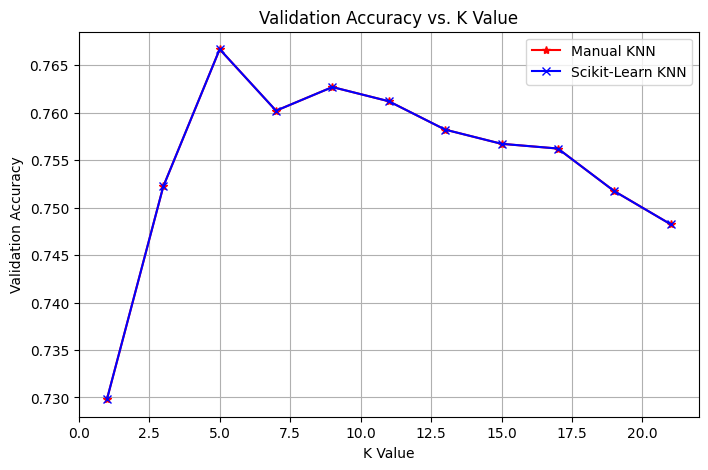

In [ ]:
#plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, manual_accuracies, 'r-*', label='Manual KNN')
plt.plot(k_values, sklearn_accuracies, 'b-x', label='Scikit-Learn KNN')
plt.title('Validation Accuracy vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

####Underfitting & Overfitting Trends
The plot shows that with a very low k, the model overfits, leading to lower validation accuracy.
With a very high k, the model underfits failing to capture important regularitirs

In [ ]:
#testing manual kNN model with optimal k
y_pred_test_manual = manual_kNN(X_train,y_train,X_test,best_k_manual)

In [ ]:
#testing scikit kNN model with optimal k
knn_test = KNeighborsClassifier(n_neighbors=best_k_sk)
knn_test.fit(X_train,y_train)
y_pred_test_sk = knn.predict(X_test)

In [ ]:
#defining a function to show all test results report
def report(y_train, y_test,model):
  accuracy = accuracy_score(y_train, y_test)
  precision = precision_score(y_train, y_test)
  recall = recall_score(y_train, y_test)
  f1 = f1_score(y_train, y_test)
  confusion = confusion_matrix(y_train, y_test)
  print(f"Report for {model} model:\n")
  print(f"Percision: {accuracy}")
  print(f"Percision: {precision}")
  print(f"Recall: {recall}")
  print(f"f1: {f1}")
  print(f"Confusion matrix: \n{confusion}\n")

In [ ]:
#printing model reports
report(y_test,y_pred_test_manual,"Manual kNN")
report(y_test,y_pred_test_sk,"Scikit kNN")

Report for Manual kNN model:

Percision: 0.7683109118086696
Percision: 0.7222707423580786
Recall: 0.8490759753593429
f1: 0.780556866446437
Confusion matrix: 
[[715 318]
 [147 827]]

Report for Scikit kNN model:

Percision: 0.7618335824613851
Percision: 0.7073578595317725
Recall: 0.8685831622176592
f1: 0.7797235023041474
Confusion matrix: 
[[683 350]
 [128 846]]

